<a href="https://colab.research.google.com/github/xelav/boosters-digital-reputation/blob/master/Boosters_experiments_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
""
root_dir = "/content/drive/My Drive/boosters"
%cd "{root_dir}"
!pip install catboost

Mounted at /content/drive
/content/drive/My Drive/boosters


# Prapare data

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy import sparse, stats
from scipy.linalg import svd
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     cross_validate, train_test_split)
from sklearn.ensemble import VotingClassifier

from tqdm import tqdm
from catboost import CatBoostClassifier

import datetime
import json
import pickle
import copy

from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost import cv as catboost_cv
from scipy import sparse

import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

In [0]:
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

X1 = pd.read_csv(TRAIN_PATH + 'X1.csv')
X2 = pd.read_csv(TRAIN_PATH + 'X2.csv')
X3 = pd.read_csv(TRAIN_PATH + 'X3.csv')

Y = pd.read_csv(TRAIN_PATH + 'Y.csv')

X1_test = pd.read_csv(TEST_PATH + 'X1.csv')
X2_test = pd.read_csv(TEST_PATH + 'X2.csv')
X3_test = pd.read_csv(TEST_PATH + 'X3.csv')

In [0]:
def get_x2_summed(X2):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    sparse_matrix = sparse.csr_matrix((len(rows), len(cols)))

    sparse_matrix[row_pos, col_pos] = 1

    return np.squeeze(np.asarray(sparse_matrix.sum(axis=1)))

# X1['X2_summed'] = get_x2_summed(X2)
# X1_test['X2_summed'] = get_x2_summed(X2_test)

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


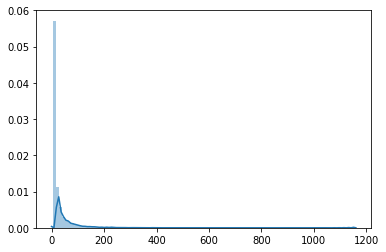

In [0]:
def transform_x2(X2, svd=None):
    rows, row_pos = np.unique(X2.iloc[:, 0], return_inverse=True)
    cols, col_pos = np.unique(X2.iloc[:, 1], return_inverse=True)
    
    sparse_matrix = sparse.csr_matrix((len(rows), len(cols)))

    sparse_matrix[row_pos, col_pos] = 1

    cols_ = sparse_matrix.sum(axis=0)
    rows_ = sparse_matrix.sum(axis=1)

    minimum_users_per_group = 5
    selected_cols = cols_ >= minimum_users_per_group
    trimmed_sparse_matrix = sparse_matrix[:, np.squeeze(np.asarray(selected_cols))]

    sns.distplot(trimmed_sparse_matrix.sum(axis=0), bins=100)

    if svd is None:
        svd = TruncatedSVD(n_components=150)
        svd.fit(trimmed_sparse_matrix)

    components = pd.DataFrame(svd.transform(trimmed_sparse_matrix))
    components['id'] = X2.iloc[:, 0].unique()
    X2 = components
    X2_summed = np.squeeze(np.asarray(sparse_matrix.sum(axis=1)))
    return X2, X2_summed, svd

X2_all = X2.append(X2_test)
X2_all, X2_summed, svd = transform_x2(X2_all)

X2_tranformed = X2_all[X2_all.id.isin(X1.id)]
df = X1.merge(X2, on='id', how='inner').merge(X3, on='id').merge(Y, on='id')
X = df.iloc[:, :-5]
X = X.drop('id', axis=1)
Y_cls = df.iloc[:, -5:]

X2_tranformed_test = X2_all[X2_all.id.isin(X1_test.id)]
df_test = X1_test.merge(X2_test, on='id', how='inner').merge(X3_test, on='id')
X_submit = df_test

In [0]:
def validate(estimator, X_train, y_train, random_state=None, n_folds=5):

    cv = KFold(n_splits=n_folds, shuffle=False, random_state=random_state)
    cv_iter = list(cv.split(X_train, y_train))

    scores=[]
    for train, test in tqdm(cv_iter):
        estimator.fit(X_train[train, :], y_train[train],
                        # eval_set=(X_train[test, :], y_train[test])
                        )
        pred_statement = estimator.predict_proba(X_train[test, :])[:, 1]
        metric = roc_auc_score(y_train[test], pred_statement)
        print(metric)
        scores.append(metric)
    return np.array(scores)

In [0]:
def make_predictions(estimator, exp_name, X_train, Y_train, X_test):
    probas = []

    for i in tqdm('12345'):

        # X_train = X1.merge(Y, on='id', suffixes=('', '_y'),).iloc[:, :-5].drop('id', axis=1).values
        y = Y_train[i].values

        estimator.fit(X_train, y)
        proba = estimator.predict_proba(X_test)[:, 1]

        probas.append(proba)

    tmp = pd.DataFrame(probas).T
    baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
    baseline['id'] = X1_test['id']
    baseline[['id', '1', '2', '3', '4', '5']].to_csv(exp_name+'.csv', index=False)

## Feature importance experiments

In [0]:
xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        'silent': True}

t=0
xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)

lgb_cls = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=300, max_depth=5, learning_rate=0.001)

cat_cls = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC", n_estimators=300,
                         loss_function='Logloss', use_best_model=False)

log_clf = LogisticRegression(penalty='l1', C=5e-5, solver='liblinear',
                         class_weight='balanced')

eclf = VotingClassifier(estimators=[('cat', cat_cls), ('xgb', xgb_cls), ('lgb', lgb_cls), ('log', log_clf)], voting='soft')

In [0]:
X3_train_summed = X3.drop('id', axis=1).multiply(1 / X3[X3 != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)
X3_test_summed = X3_test.drop('id', axis=1).multiply(1 / X3_test[X3_test != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)

X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .assign(X3_summed_dernomalized=X3_train_summed)\
    .assign(X3_non_zero_count=(X3.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3.drop('id', axis=1).mean(axis=1))\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .assign(X3_summed_dernomalized=X3_test_summed)\
    .assign(X3_non_zero_count=(X3_test.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3_test.drop('id', axis=1).mean(axis=1))\
    .values


# print(validate(eclf, X_train, y_train, random_state=None, n_folds=5).mean())

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


## Feature importance

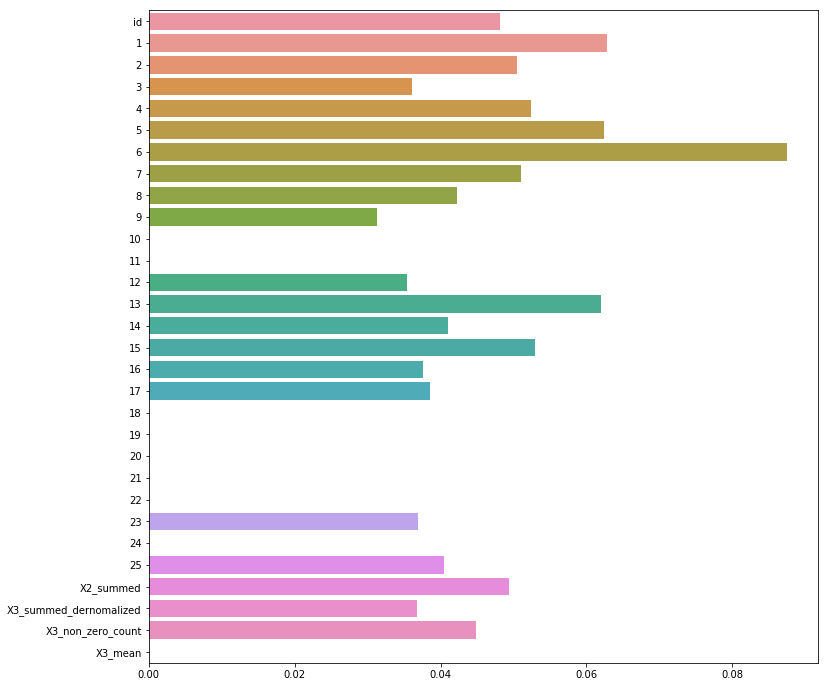

In [0]:
xgb_cls = xgb.XGBClassifier(n_jobs=8, random_state=0, **xgb_params)

xgb_cls.fit(X_train.values, Y['5'])

plt.figure(figsize=(12,12))
sns.barplot(x=xgb_cls.feature_importances_,y=X_train.columns)

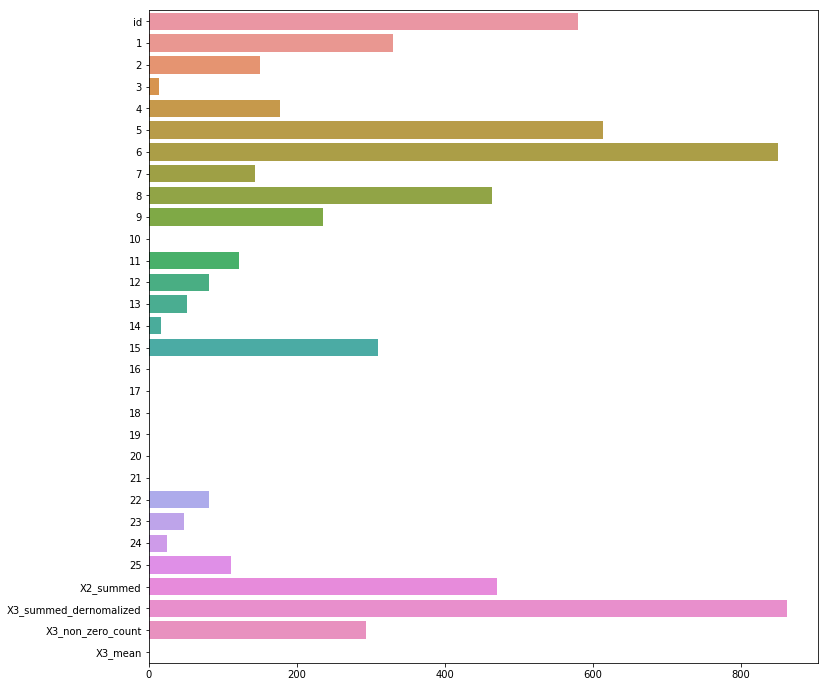

In [0]:
lgb_cls = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=300, max_depth=5, learning_rate=0.001)

lgb_cls.fit(X_train.values, Y['5'])

plt.figure(figsize=(12,12))
sns.barplot(x=lgb_cls.feature_importances_, y=X_train.columns)

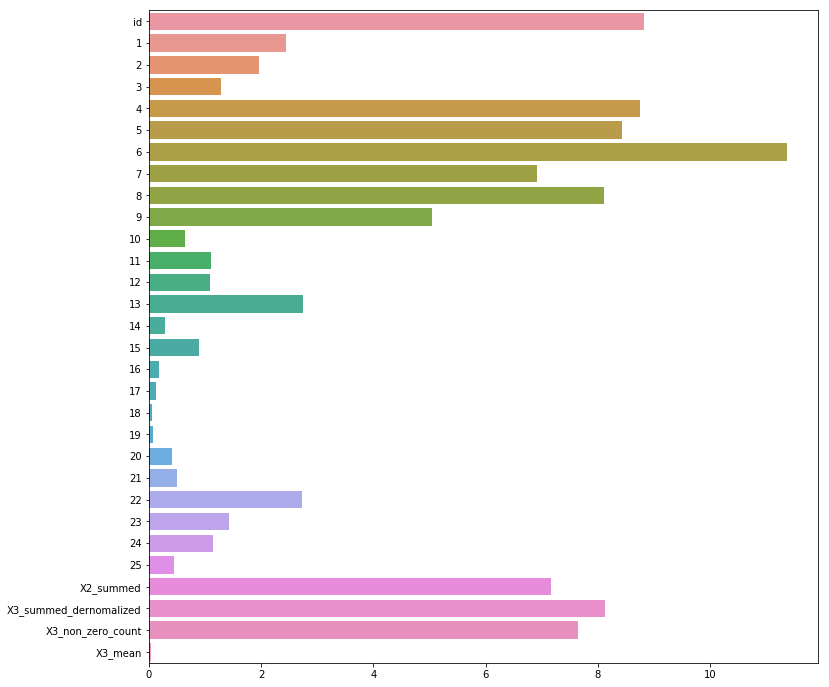

In [0]:
cat_cls = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC",
                         loss_function='Logloss', use_best_model=False, n_estimators=200)

cat_cls.fit(X_train.values, Y['5'])

plt.figure(figsize=(12,12))
sns.barplot(x=cat_cls.feature_importances_, y=X_train.columns)

In [0]:
cat_cls.feature_importances_ > cat_cls.feature_importances_.mean()

array([ True, False, False, False,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False])

In [0]:
X2_tranformed['id']

0          3
1          5
2          6
3          8
4         10
5         11
6         13
7         15
8         17
9         18
10        19
11        20
12        22
13        24
14        25
15        27
16        28
17        29
18        30
19        34
20        36
21        42
22        43
23        45
24        46
25        49
26        50
27        51
28        56
29        57
        ... 
3970    8005
3971    8006
3972    8007
3973    8011
3974    8014
3975    8015
3976    8017
3977    8018
3978    8020
3979    8022
3980    8029
3981    8030
3982    8031
3983    8032
3984    8033
3985    8034
3986    8035
3987    8036
3988    8037
3989    8040
3990    8042
3991    8044
3992    8045
3993    8048
3994    8049
3995    8051
3996    8052
3997    8053
3998    8055
3999    8056
Name: id, Length: 4000, dtype: int64

In [0]:
model = xgb_cls
X_tmp = X3.drop('id', axis=1)

y_train=Y['5']

selection = SelectFromModel(model, threshold=None, prefit=False)
select_X_train = selection.fit_transform(X_tmp.values, y_train)

print('Mean:  ',validate(model, X_tmp.values, y_train, random_state=0).mean())
print('Mean:  ',validate(model, select_X_train, y_train, random_state=0).mean())

 20%|██        | 1/5 [00:01<00:04,  1.02s/it]

0.5322074288277072


 40%|████      | 2/5 [00:02<00:03,  1.03s/it]

0.48407943979189166


 60%|██████    | 3/5 [00:03<00:02,  1.03s/it]

0.46665862290862287


 80%|████████  | 4/5 [00:04<00:01,  1.03s/it]

0.5031336208972268


  0%|          | 0/5 [00:00<?, ?it/s]

0.47961788800359106
Mean:   0.4931394000858079


 20%|██        | 1/5 [00:00<00:00,  4.13it/s]

0.5827459485511176


 40%|████      | 2/5 [00:00<00:00,  4.10it/s]

0.5229944780650815


 60%|██████    | 3/5 [00:00<00:00,  4.10it/s]

0.5117304804804805


 80%|████████  | 4/5 [00:00<00:00,  4.03it/s]

0.5520710791901431


100%|██████████| 5/5 [00:01<00:00,  4.01it/s]

0.5092897822915498
Mean:   0.5357663537156745


## Merging

In [0]:
final_probes=[]

xgb_params = {'objective': 'binary:logistic', 
        'eval_metric': 'auc',
        'eta': 0.001,
        'max_depth': 1, 
        'subsample': 0.6, 
        'colsample_bytree': 0.6,
        'alpha':0.001,
        'silent': True}

for target in tqdm('12345'):

    probas = []

    for rnd in range(10):

        model = xgb.XGBClassifier(n_jobs=8, random_state=rnd, **xgb_params)

        y_train=Y[target]

        selection = SelectFromModel(model, threshold=None, prefit=False)
        selection.fit(X3.drop('id', axis=1).values, y_train)

        select_X3_train = selection.transform(X3.drop('id', axis=1).values)
        select_X3_train = pd.DataFrame(select_X3_train)
        select_X3_train['id'] = X3['id'].values

        select_X3_test = selection.transform(X3_test.drop('id', axis=1).values)
        select_X3_test = pd.DataFrame(select_X3_test)
        select_X3_test['id'] = X3_test['id'].values
        # print("X3 selected!")

        selection = SelectFromModel(model, threshold=None, prefit=False)
        selection.fit(X2_tranformed.drop('id', axis=1).values, y_train)
        
        select_X2_train = selection.transform(X2_tranformed.drop('id', axis=1).values)
        select_X2_train = pd.DataFrame(select_X2_train)
        select_X2_train['id'] = X2_tranformed['id'].values

        select_X2_test = selection.transform(X2_tranformed_test.drop('id', axis=1).values)
        select_X2_test = pd.DataFrame(select_X2_test)
        select_X2_test['id'] = X2_tranformed_test['id'].values
        # print("X2 selected!")

        X_train = X1\
            .assign(X2_summed=get_x2_summed(X2))\
            .assign(X3_summed_dernomalized=X3_train_summed)\
            .assign(X3_non_zero_count=(X3.drop('id',axis=1) != 0).sum(axis=1))\
            .assign(X3_mean=X3.drop('id', axis=1).mean(axis=1))\
            .merge(select_X3_train, on='id')\
            .merge(select_X2_train, on='id')\
            .merge(Y, on='id', suffixes=('', '_y'),)\
            .iloc[:, :-5]

        X_test = X1_test\
            .assign(X2_summed=get_x2_summed(X2_test))\
            .assign(X3_summed_dernomalized=X3_test_summed)\
            .assign(X3_non_zero_count=(X3_test.drop('id',axis=1) != 0).sum(axis=1))\
            .assign(X3_mean=X3_test.drop('id', axis=1).mean(axis=1))\
            .merge(select_X3_test, on='id')\
            .merge(select_X2_test, on='id')

        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:, 1]

        probas.append(proba)

    final_probes.append(np.array(probas).mean(axis=0))

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
 60%|██████    | 3/5 [01:50<01:13, 36.87s/it]

X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
 80%|████████  | 4/5 [02:28<00:36, 36.96s/it]

X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


X3 selected!
X2 selected!


/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 5/5 [03:04<00:00, 36.95s/it]


In [0]:
tmp = pd.DataFrame(final_probes).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('feature_selection-xgb-mean_10'+'.csv', index=False)

0.57384 :(

## Second attempt

In [0]:
X3_train_summed = X3.drop('id', axis=1).multiply(1 / X3[X3 != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)
X3_test_summed = X3_test.drop('id', axis=1).multiply(1 / X3_test[X3_test != 0].drop('id', axis=1).min(axis=1), axis=0).sum(axis=1)

X_train = X1\
    .assign(X2_summed=get_x2_summed(X2))\
    .assign(X3_summed_dernomalized=X3_train_summed)\
    .assign(X3_non_zero_count=(X3.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3.drop('id', axis=1).mean(axis=1))\
    .merge(X3, on='id')\
    .merge(X2_tranformed, on='id')\
    .merge(Y, on='id', suffixes=('', '_y'),)\
    .iloc[:, :-5]

X_test = X1_test\
    .assign(X2_summed=get_x2_summed(X2_test))\
    .assign(X3_summed_dernomalized=X3_test_summed)\
    .assign(X3_non_zero_count=(X3_test.drop('id',axis=1) != 0).sum(axis=1))\
    .assign(X3_mean=X3_test.drop('id', axis=1).mean(axis=1))\
    .merge(X3_test, on='id')\
    .merge(X2_tranformed_test, on='id')

/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.6/dist-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [0]:
probas = []

for target in tqdm('12345'):

    y_train = Y[target]

    model = xgb.XGBClassifier(n_jobs=8, random_state=rnd, **xgb_params)
    selection = SelectFromModel(model, threshold=0.01, prefit=False)
    select_X_train = selection.fit_transform(X_train.values, y_train)
    select_X_test = selection.transform(X_test.values)

    model.fit(select_X_train, y_train)
    proba = model.predict_proba(select_X_test)[:, 1]

    probas.append(proba)

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('feature_selection-xgb'+'.csv', index=False)

100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


In [0]:
np.zeros(X_test.shape[0])

(4058,)

In [0]:
probas = []

for target in tqdm('12345'):

    y_train = Y[target]

    xgb_cls = xgb.XGBClassifier(n_jobs=8, **xgb_params)

    lgb_cls = lgb.LGBMClassifier(objective='cross_entropy', n_estimators=300, max_depth=5, learning_rate=0.001)

    cat_cls = CatBoostClassifier(verbose=False, task_type="GPU", eval_metric="AUC", n_estimators=300,
                            loss_function='Logloss', use_best_model=False)

    scores = np.zeros(X_test.shape[0])
    for model in tqdm([cat_cls, lgb_cls, xgb_cls]):

        selection = SelectFromModel(model, threshold=None, prefit=False)
        select_X_train = selection.fit_transform(X_train.values, y_train)
        select_X_test = selection.transform(X_test.values)

        model.fit(select_X_train, y_train)
        proba = model.predict_proba(select_X_test)[:, 1]
        scores += proba
    scores /= 3
    probas.append(scores)

tmp = pd.DataFrame(probas).T
baseline = pd.DataFrame(tmp.values, columns=['1', '2', '3', '4', '5'])
baseline['id'] = X1_test['id']
baseline[['id', '1', '2', '3', '4', '5']].to_csv('feature_selection-xgb-cat-lgb'+'.csv', index=False)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:26, 13.18s/it]

 67%|██████▋   | 2/3 [00:28<00:13, 13.77s/it]

100%|██████████| 3/3 [00:30<00:00, 10.35s/it]


 20%|██        | 1/5 [00:30<02:02, 30.71s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:23, 11.59s/it]

 67%|██████▋   | 2/3 [00:26<00:12, 12.62s/it]

100%|██████████| 3/3 [00:28<00:00,  9.53s/it]


 40%|████      | 2/5 [00:59<01:30, 30.19s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:12<00:24, 12.01s/it]

 67%|██████▋   | 2/3 [00:27<00:13, 13.11s/it]

100%|██████████| 3/3 [00:30<00:00,  9.89s/it]


 60%|██████    | 3/5 [01:29<01:00, 30.16s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:23, 11.60s/it]

 67%|██████▋   | 2/3 [00:26<00:12, 12.45s/it]

100%|██████████| 3/3 [00:28<00:00,  9.42s/it]


 80%|████████  | 4/5 [01:58<00:29, 29.64s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎

In [0]:
eclf.feature_importances_

AttributeError: ignored